# GP prediction for multiple 1D inputs with nodatas: what performs best?

In this notebook, we investigate **the computational speed of 1D Gaussian Process prediction for multiple inputs containing nodata values** using:
- A simple "for" loop around a 1D prediction (both **GPyTorch** and **SciKit-Learn**),
- A 2D prediction for with negligible covariance along the 2nd dimension (both **GPyTorch** and **SciKit-Learn**),
- The batch 1D implementation of **GPyTorch**.

To do this, **we will evaluate the GP over a dataset of size N x K with increasing N values, and compute the associated speed**.

We also test when possible for each method:
- Their GPU implementation (only **GPyTorch**),
- Without or with LancZos Variance Estimates (LOVE) method implemented in **GPyTorch**, using different ranks.

The challenges associated with nodata values is detailed further below for each method.

We call functions living in:
- */spacetime/models.py* to define the models and predict on input data with **fixed covariance parameters**.
- */spacetime/scaling.py* to use routines specific to scaling.

**There is no training, we are only interested in prediction! Covariance is defined arbitrarily.**

In [7]:
import os
import sys
import numpy as np
import time
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.dpi'] = 150

sys.path.insert(0, "..")
import spacetime.models
import spacetime.scaling

# To restart kernel
# os._exit(00)

## Create multiple 1D data with nodatas (NaNs) as a 2D data array

We repeat N times the same data series shown below across columns of a 2D array, randomly keeping only 10 valid values (different for each column).

This will create a N x 100 dataset, and **we will loop over N** to test the scaling for large multiple 1D data.

In [8]:
# 1D data from https://blog.dominodatalab.com/fitting-gaussian-process-models-python/
data = np.array([
     [-5.01, 1.06], [-4.90, 0.92], [-4.82, 0.35], [-4.69, 0.49], [-4.56, 0.52],
     [-4.52, 0.12], [-4.39, 0.47], [-4.32,-0.19], [-4.19, 0.08], [-4.11,-0.19],
     [-4.00,-0.03], [-3.89,-0.03], [-3.78,-0.05], [-3.67, 0.10], [-3.59, 0.44],
     [-3.50, 0.66], [-3.39,-0.12], [-3.28, 0.45], [-3.20, 0.14], [-3.07,-0.28],
     [-3.01,-0.46], [-2.90,-0.32], [-2.77,-1.58], [-2.69,-1.44], [-2.60,-1.51],
     [-2.49,-1.50], [-2.41,-2.04], [-2.28,-1.57], [-2.19,-1.25], [-2.10,-1.50],
     [-2.00,-1.42], [-1.91,-1.10], [-1.80,-0.58], [-1.67,-1.08], [-1.61,-0.79],
     [-1.50,-1.00], [-1.37,-0.04], [-1.30,-0.54], [-1.19,-0.15], [-1.06,-0.18],
     [-0.98,-0.25], [-0.87,-1.20], [-0.78,-0.49], [-0.68,-0.83], [-0.57,-0.15],
     [-0.50, 0.00], [-0.38,-1.10], [-0.29,-0.32], [-0.18,-0.60], [-0.09,-0.49],
     [0.03 ,-0.50], [0.09 ,-0.02], [0.20 ,-0.47], [0.31 ,-0.11], [0.41 ,-0.28],
     [0.53 , 0.40], [0.61 , 0.11], [0.70 , 0.32], [0.94 , 0.42], [1.02 , 0.57],
     [1.13 , 0.82], [1.24 , 1.18], [1.30 , 0.86], [1.43 , 1.11], [1.50 , 0.74],
     [1.63 , 0.75], [1.74 , 1.15], [1.80 , 0.76], [1.93 , 0.68], [2.03 , 0.03],
     [2.12 , 0.31], [2.23 ,-0.14], [2.31 ,-0.88], [2.40 ,-1.25], [2.50 ,-1.62],
     [2.63 ,-1.37], [2.72 ,-0.99], [2.80 ,-1.92], [2.83 ,-1.94], [2.91 ,-1.32],
     [3.00 ,-1.69], [3.13 ,-1.84], [3.21 ,-2.05], [3.30 ,-1.69], [3.41 ,-0.53],
     [3.52 ,-0.55], [3.63 ,-0.92], [3.72 ,-0.76], [3.80 ,-0.41], [3.91 , 0.12],
     [4.04 , 0.25], [4.13 , 0.16], [4.24 , 0.26], [4.32 , 0.62], [4.44 , 1.69],
     [4.52 , 1.11], [4.65 , 0.36], [4.74 , 0.79], [4.84 , 0.87], [4.93 , 1.01],
     [5.02 , 0.55]
])

# Function to create 2D data with the same time series repeated along first axis with random NaNs
def data2d_repeat_nans(data: np.ndarray, dc_size: int):

    dc = np.moveaxis(np.tile(data[:, 1], dc_size).reshape((dc_size, data.shape[0])), 1, 0)
    np.random.seed(42)
    for i in range(dc_size):
        # Randomly remove data from the time series
        ind_subsample_data = np.random.choice(len(data), 50, replace=False)
        ind_boolean = np.ones(len(data), dtype=bool)
        ind_boolean[ind_subsample_data] = False
        dc[ind_boolean, i] = np.nan
        dc[:, i] -= np.nanmean(dc[:, i])

    return dc

## Define output grid and fix covariance

In [9]:
# Define the 1D prediction grid, and covariance model
gridx = np.linspace(-6, 6, 200)
variogram_model = {"model_name": "gaussian", "range": 2, "psill": 2, "nugget": 0.01}

## Define specific parameters

In [10]:
# Maximum size for 2D case (larger blows up memory)
smax_2d = 100

# Parameters to test for GPyTorch
gpu_pars = [False, True]
gpu_tags = ["cpu", "gpu"]
love_pars = [False, True]
love_tags = ["nolove", "love"]
rank_pars = [10, 100]
rank_tags = [str(r) for r in rank_pars]
comb_pars = [(gpu, love, rank) for gpu in gpu_pars for love in love_pars for rank in rank_pars]
comb_tags = [(gpu, love, rank) for gpu in gpu_tags for love in love_tags for rank in rank_tags]

## Evaluate GP over dataset of increasing size for each method

Summary of each method and its benefits/drawbacks below.

**Method 1, loop over single 1D GP.**

*Benefits:* Easy to filter NaNs in each series.

*Drawbacks:* Probably the longest, looping over every single pixel!

**Method 2, use a 2D GP with a negligible range (= lengthscale) in the 2nd dimension.**

*Benefits:* Easy to filter NaNs in the dataset and pass a series of points.

*Drawbacks:* Only gives the same results for second-order stationary kernels (the GP is computed on all data at once: need detrend per 1D data series ahead rather than use non-stationary kernels, and also remove the mean). Probably takes much longer to compute.

**Method 3, use batch 1D GP.**

*Benefits:* Should be the fastest.

*Drawbacks:* Need to pass a full N x K batch, of same size for all points. Need to "trick" the algorithm to take care of nodatas properly. Here, we give a false coordinate very far from the prediction area (further than the correlation range). But this might not work for non-stationary kernels...

In [11]:
# Loop over a different dataset size
list_sizes = [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000]
list_df_s = []
for s in list_sizes:

    # Create 2D data stack
    dc = data2d_repeat_nans(data=data, dc_size=s)

    # Index of the 2D stack where we'll compute the residuals
    k = 0

    #####################################################################
    # Method 1: Loop 1D prediction across each time series in the 2D data
    #####################################################################
    
    # For SciKit-Learn
    t = time.time()
    y_skl, sig_skl = spacetime.scaling.loop_predict_1d(spacetime.models.sklearn_predict_1d, variogram_model, gridx,
                                                       data[:, 0], dc)
    elaps_skl = time.time() - t
    df_skl_1d = pd.DataFrame(data={"method": "skl_1d", "elaps": elaps_skl, "y": y_skl[:, k], "sig": sig_skl[:, k]})

    # For GPyTorch, test all combinaison of GPU + LOVE + rank parameters
    list_df_comb = []
    for i in range(len(comb_pars)):
        # Loop over the 2D data with a 1D GP
        t = time.time()
        y_gpy, sig_gpy = spacetime.scaling.loop_predict_1d(spacetime.models.gpytorch_predict_1d,
                                                           variogram_model, gridx, data[:, 0], dc,
                                                           use_gpu=comb_pars[i][0], love=comb_pars[i][1],
                                                           rank=comb_pars[i][2])
        elaps_gpy = time.time() - t
        # Save to dataframe
        df_comb = pd.DataFrame(data={"method": "gpy_1d_"+"_".join(list(comb_tags[i])), "elaps": elaps_gpy,
                                     "y": y_gpy[:, k], "sig": sig_gpy[:, k]})
        list_df_comb.append(df_comb)
    df_gpy_1d = pd.concat(list_df_comb)

    ############################################################################################################################
    # Method 2: Use 2D prediction (1D time + 1D space) with "useless" kernel in space dimension (lengthscale << new D grid size)
    ############################################################################################################################
    
    # Memory maxes out very fast, run only until sample size of 20
    if s <= smax_2d:

        # We define placeholder coordinates and covariance for the spatial dimension, to have no effect on the prediction

        # Placeholder covariance: partial sill needs to equal 1 because of kernel mult and range be much smaller than grid size of 1
        variogram_model_space = {"model_name": "gaussian", "range": 0.0001, "psill": 1, "nugget": 0.0001}

        # # Reshape to 2D and create spatial grid spaced by 1 >> 0.01 range defined above
        gridy = np.arange(0, dc.shape[1])
        # Flatten the data to 2D coordinates and 1D values, keeping only valid data
        list_y_in, list_x1, list_x2 = ([] for i in range(3))
        for i in range(dc.shape[1]):

            # Keep only valid values
            y_in = dc[:, i]
            ind_valid = np.isfinite(y_in)

            # Subsample the values, and two coordinates
            y_in = y_in[ind_valid]
            x1 = data[:, 0][ind_valid]
            x2 = np.ones(len(x1)) * i  # For the 1D spatial coordinate, we simply use a distance of 1 >> range

            list_y_in.append(y_in)
            list_x1.append(x1)
            list_x2.append(x2)

        y_in_all = np.concatenate(list_y_in)
        x1_all = np.concatenate(list_x1)
        x2_all = np.concatenate(list_x2)

        data_2d = np.dstack((x1_all, x2_all, y_in_all)).squeeze()

        # GPyTorch
        t = time.time()
        yy_gpy, ss_gpy = spacetime.scaling.gpytorch_predict_2d_product(variogram_model1=variogram_model,
                                                                       variogram_model2=variogram_model_space,
                                                                       gridx=gridx, gridy=gridy, data=data_2d)[0:2]
        ee_gpy = time.time() - t
        yy_gpy = yy_gpy.reshape((len(gridy), len(gridx))).T
        ss_gpy = ss_gpy.reshape((len(gridy), len(gridx))).T
        df_gpy_2d = pd.DataFrame(data={"method": "gpy_2d", "elaps": ee_gpy, "y": yy_gpy[:, k], "sig": ss_gpy[:, k]})

        # SciKit-Learn
        t = time.time()
        yy_skl, ss_skl = spacetime.scaling.sklearn_predict_2d_product(variogram_model1=variogram_model,
                                                                      variogram_model2=variogram_model_space,
                                                                      gridx=gridx, gridy=gridy, data=data_2d)[0:2]
        ee_skl = time.time() - t
        yy_skl = yy_skl.reshape((len(gridy), len(gridx))).T
        ss_skl = ss_skl.reshape((len(gridy), len(gridx))).T
        df_skl_2d = pd.DataFrame(data={"method": "skl_2d", "elaps": ee_skl, "y": yy_skl[:, k], "sig": ss_skl[:, k]})
    else:
        df_gpy_2d = pd.DataFrame(data={"method": "gpy_2d", "elaps": [np.nan], "y": [np.nan], "sig": [np.nan]})
        df_skl_2d = pd.DataFrame(data={"method": "skl_2d", "elaps": [np.nan], "y": [np.nan], "sig": [np.nan]})

    ##########################
    # Method 3: Batch GP in 1D
    ##########################
    
    # Prepare the data to be in batch format (batch dimension first, for both data and repeated 1D coordinates)
    data_batch = dc.T.copy()
    x_in = np.repeat(data[:, 0].reshape(1, -1), dc.shape[1], axis=0)

    # Problem of batch GP is the fixed shape, while we have NaNs in our data...
    # Let's try to solve this by converting NaNs to the mean of the data, and their coordinate a values way further than the kernel range from the prediction area
    ind_invalid = ~np.isfinite(data_batch)
    x_in[ind_invalid] = 100  # 100 is way off the prediction window of [-6, +6]
    data_batch[ind_invalid] = np.repeat(np.nanmean(data_batch, axis=1).reshape(-1, 1), data_batch.shape[1], axis=1)[ind_invalid]  # Replace by mean value along each 1D axis to not bias the GP mean

    # Perform all combinations of GPyTorch parameters
    list_df_comb2 = []
    for i in range(len(comb_pars)):
        # Predict with Batch 1D GP
        t0 = time.time()
        yb, sb, mb = spacetime.scaling.gpytorch_predict_1d_batch(variogram_model, gridx, x_in, data_batch,
                                                                 use_gpu=comb_pars[i][0], love=comb_pars[i][1],
                                                                 rank=comb_pars[i][2])
        elaps_b = time.time() - t0
        # Save to dataframe
        df_comb2 = pd.DataFrame(data={"method": "gpy_batch1d_" + "_".join(list(comb_tags[i])), "elaps": elaps_b,
                                     "y": yb[k, :], "sig": sb[k, :]})
        list_df_comb2.append(df_comb2)
    df_gpy_batch1d = pd.concat(list_df_comb2)

    # Aggregate all dataframes, write batch size for this loop and append to list of dataframes
    df_s = pd.concat([df_skl_1d, df_gpy_1d, df_skl_2d, df_gpy_2d, df_gpy_batch1d])
    df_s["batch_size"] = s
    list_df_s.append(df_s)

# Concatenate all results
df = pd.concat(list_df_s)

## Comparison of each method without GPyTorch specific options (no GPU, no LOVE)

First, let's check visually that all methods yield the same result.

We compare the prediction over the first series of 1D data, for the batch size N of 2 (later, we do more quantitative analysis of prediction accuracy for all batch sizes).

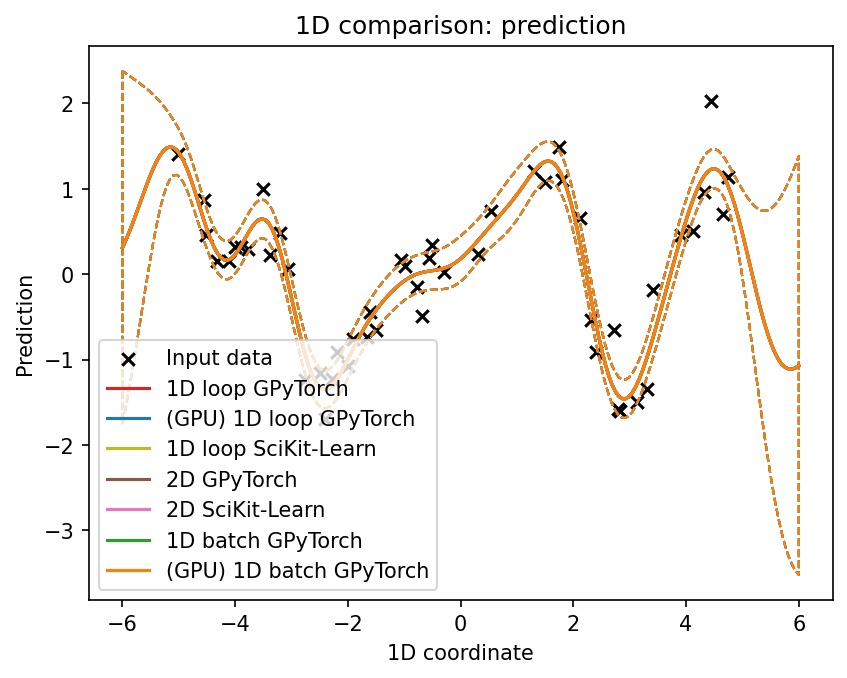

In [12]:
# Prediction plot to visualize the results
plt.figure()
ind_valid = np.isfinite(dc[:, k])
plt.scatter(data[:, 0][ind_valid], dc[:, k][ind_valid], c='black', marker="x", label="Input data")

df_s2 = df[df.batch_size == 2]
list_methods = ["gpy_1d_cpu_nolove_10", "gpy_1d_gpu_nolove_10", "skl_1d", "gpy_2d", "skl_2d",
                "gpy_batch1d_cpu_nolove_10", "gpy_batch1d_gpu_nolove_10"]
list_labels = ["1D loop GPyTorch", "(GPU) 1D loop GPyTorch", "1D loop SciKit-Learn", "2D GPyTorch", "2D SciKit-Learn",
               "1D batch GPyTorch", "(GPU) 1D batch GPyTorch"]
list_cols = ["tab:red", "tab:blue", "tab:olive", "tab:brown", "tab:pink", "tab:green", "tab:orange"]

for method in list_methods:
    df_method = df_s2[df_s2.method == method]
    i = list_methods.index(method)
    plt.plot(gridx, df_method.y, c=list_cols[i], label=list_labels[list_methods.index(method)])
    plt.fill_between(gridx, df_method.y - 2 * df_method.sig, df_method.y + 2 * df_method.sig,
                     edgecolor=list_cols[i], facecolor="None", linestyle="dashed")

plt.xlabel("1D coordinate")
plt.ylabel("Prediction")
plt.title("1D comparison: prediction")
plt.legend()
plt.show()

Good news, **we are predicting the same result with each method!** 

Now we compare the speed of each method for varying batch sizes.

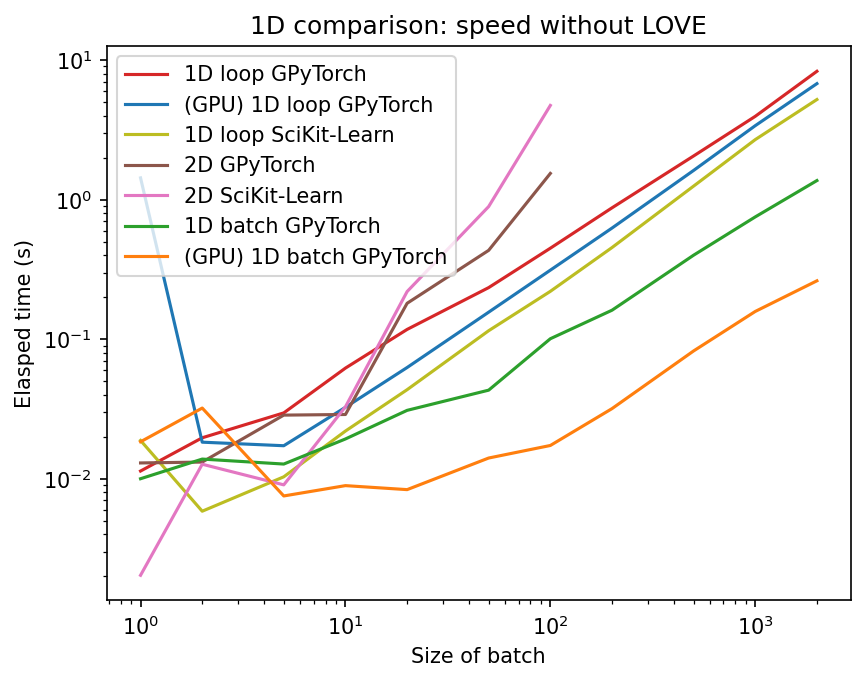

In [13]:
# Speed performance plot

plt.figure()
for method in list_methods:
    i = list_methods.index(method)
    plt.plot(list_sizes, [df[(df.method == method) & (df.batch_size == b)].elaps[0] for b in list_sizes],
             label=list_labels[list_methods.index(method)], color=list_cols[i])
plt.xlabel("Size of batch")
plt.ylabel("Elasped time (s)")
plt.yscale("log")
plt.xscale("log")
plt.title("1D comparison: speed without LOVE")
plt.legend()

**The two major speed-ups seem to come from using the batch implementation of GPyTorch, and the GPU scaling of GPyTorch.**

Let's quantify the accuracy of all those methods more exhaustively, computing the mean value of the residuals between a certain method and the loop 1D GPyTorch method.

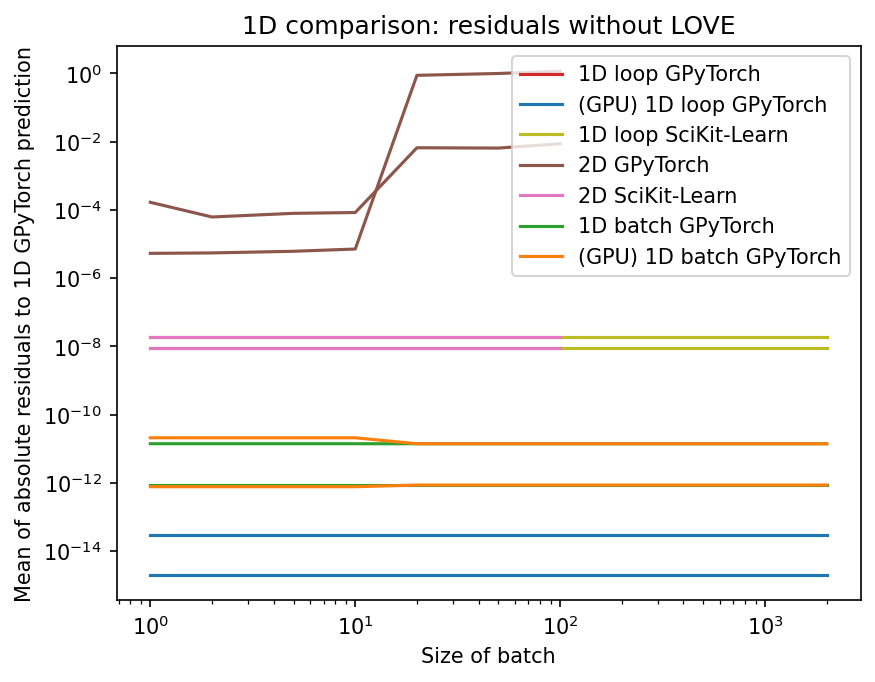

In [14]:
# Accuracy plot
plt.figure()
for method in list_methods:

    i = list_methods.index(method)

    list_y_method = [df[(df.method == method) & (df.batch_size == b)].y.values for b in list_sizes]
    list_sig_method = [df[(df.method == method) & (df.batch_size == b)].sig.values for b in list_sizes]
    list_y_gpy = [df[(df.method == "gpy_1d_cpu_nolove_10") & (df.batch_size == b)].y.values for b in list_sizes]
    list_sig_gpy = [df[(df.method == "gpy_1d_cpu_nolove_10") & (df.batch_size == b)].sig.values for b in list_sizes]

    res_mean = [np.mean(np.abs(list_y_method[i] - list_y_gpy[i])) for i in range(len(list_sizes))]
    res_sig = [np.mean(np.abs(list_sig_method[i] - list_sig_gpy[i])) for i in range(len(list_sizes))]

    plt.plot(list_sizes, res_mean, color=list_cols[i], label=list_labels[list_methods.index(method)])
    plt.plot(list_sizes, res_sig, color=list_cols[i])

plt.xlabel("Size of batch")
plt.ylabel("Mean of absolute residuals to 1D GPyTorch prediction")
plt.yscale("log")
plt.xscale("log")
plt.title("1D comparison: residuals without LOVE")
plt.legend()

We can see that we lose a tiny bit of precision with the 2D method, especially in GPyTorch.

In particular, **the predicted std becomes wrong after reaching a batch size of 10-20** (residual in the order of magnitude of the input values).
Some side testing shows that this is related to the LOVE estimation for the 2D case (currently activated), that dramatically speeds-up the prediction at the cost of precision for larger 2D input.

## Comparison of GPyTorch specific options (GPU, LOVE, rank of LOVE)

GPyTorch offers acceleration using the GPU, and fast prediction using LansZos Variance Estimates (LOVE): https://docs.gpytorch.ai/en/stable/examples/02_Scalable_Exact_GPs/Simple_GP_Regression_With_LOVE_Fast_Variances_and_Sampling.html.

We compare those options below.

In [15]:
# We remove some tags, need to compare only GPyTorch 1D and batch 1D with/without LOVE/GPU and different ranks
comb_tags.remove(("cpu", "nolove", "100"))
comb_tags.remove(("gpu", "nolove", "100"))
list_method_tags = ["_".join(tag) for tag in comb_tags]
list_label_tags = ["{}, {}, rank: {}".format(tag[0], tag[1], tag[2]) for tag in comb_tags]

First, let's look at the speed between these options.

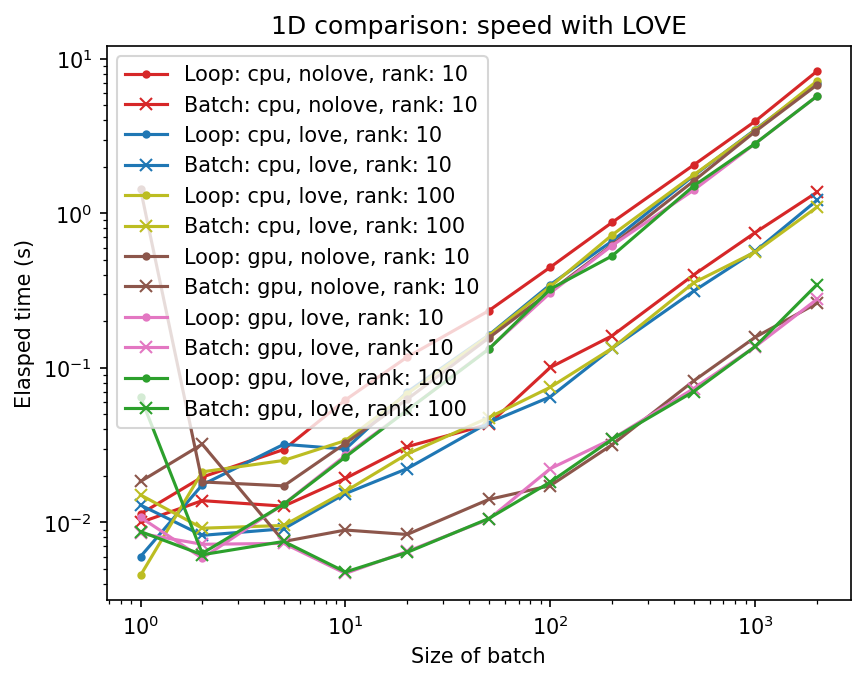

In [16]:
plt.figure()
for method_tag in list_method_tags:
    i = list_method_tags.index(method_tag)
    method_1d = "gpy_1d_"+method_tag
    method_batch = "gpy_batch1d_"+method_tag
    plt.plot(list_sizes, [df[(df.method == method_1d) & (df.batch_size == b)].elaps[0] for b in list_sizes],
             label="Loop: " + list_label_tags[list_method_tags.index(method_tag)], color=list_cols[i], marker=".")
    plt.plot(list_sizes, [df[(df.method == method_batch) & (df.batch_size == b)].elaps[0] for b in list_sizes],
             label="Batch: " + list_label_tags[list_method_tags.index(method_tag)], color=list_cols[i], marker="x")
plt.xlabel("Size of batch")
plt.ylabel("Elasped time (s)")
plt.yscale("log")
plt.xscale("log")
plt.title("1D comparison: speed with LOVE")
plt.legend()

**The LOVE method and rank option have little effect for the 1D or 1D batch cases.**

We also check the accuracy from the residuals.

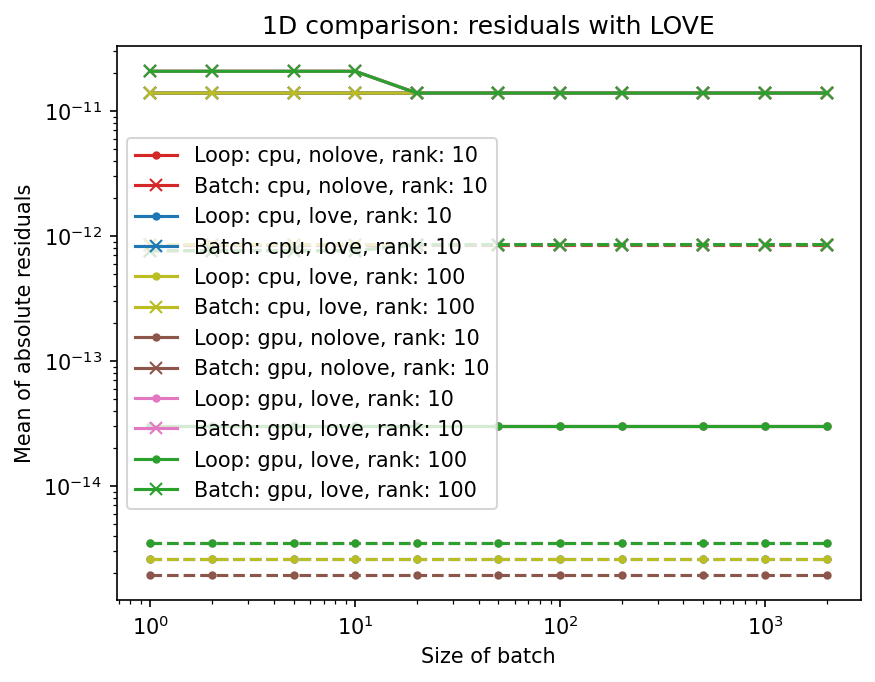

In [17]:
plt.figure()
for method_tag in list_method_tags:
    i = list_method_tags.index(method_tag)
    method_1d = "gpy_1d_"+method_tag
    method_batch = "gpy_batch1d_"+method_tag
    list_marker = [".", "x"]
    loop_or_batch = ["Loop", "Batch"]
    list_methods = [method_1d, method_batch]

    for method in list_methods:

        marker = list_marker[list_methods.index(method)]
        lob = loop_or_batch[list_methods.index(method)]

        list_y_method = [df[(df.method == method) & (df.batch_size == b)].y.values for b in list_sizes]
        list_sig_method = [df[(df.method == method) & (df.batch_size == b)].sig.values for b in list_sizes]
        list_y_gpy = [df[(df.method == "gpy_1d_cpu_nolove_10") & (df.batch_size == b)].y.values for b in list_sizes]
        list_sig_gpy = [df[(df.method == "gpy_1d_cpu_nolove_10") & (df.batch_size == b)].sig.values for b in list_sizes]

        res_mean = [np.mean(np.abs(list_y_method[i] - list_y_gpy[i])) for i in range(len(list_sizes))]
        res_sig = [np.mean(np.abs(list_sig_method[i] - list_sig_gpy[i])) for i in range(len(list_sizes))]

        plt.plot(list_sizes, res_mean, color=list_cols[i], marker=marker, label=lob + ": "+ list_label_tags[list_method_tags.index(method_tag)])
        plt.plot(list_sizes, res_sig, color=list_cols[i], linestyle="dashed", marker=marker)

plt.xlabel("Size of batch")
plt.ylabel("Mean of absolute residuals")
plt.yscale("log")
plt.xscale("log")
plt.title("1D comparison: residuals with LOVE")
plt.legend()

**All residuals are very small, all produced estimations are exactly the same!**

In conclusion, **using a batch 1D GP with GPU acceleration is the best option**.
**It however requires to "trick" the GP by moving NaNs to dubious coordinates** far from the range. It is unsure if this method works for non-stationary kernels...

That will be the next notebook!